In [1]:
#### 

import torch
import sys
sys.path.append("..")
from singleVis.data import NormalDataProvider
REF_PATH = "/home/yifan/dataset/resnetwithoutnoise/pairflip/cifar10/0"

CLEAN_PATH = "/home/yifan/dataset/resnetnoise/pairflip/cifar10/0"
sys.path.append(REF_PATH)


from config import config

SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
GPU_ID = config["GPU"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
PREPROCESS = VISUALIZATION_PARAMETER["PREPROCESS"]
LAMBDA = VISUALIZATION_PARAMETER["LAMBDA"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
INIT_NUM = VISUALIZATION_PARAMETER["INIT_NUM"]
ALPHA = VISUALIZATION_PARAMETER["ALPHA"]
BETA = VISUALIZATION_PARAMETER["BETA"]
MAX_HAUSDORFF = VISUALIZATION_PARAMETER["MAX_HAUSDORFF"]
# HIDDEN_LAYER = VISUALIZATION_PARAMETER["HIDDEN_LAYER"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
T_N_EPOCHS = VISUALIZATION_PARAMETER["T_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = 'vis'
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]

SEGMENTS = [(EPOCH_START, EPOCH_END)]
# define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))


ref_provider = NormalDataProvider(REF_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)
tar_provider = NormalDataProvider(CLEAN_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)
ref_train_data = ref_provider.train_representation(200).squeeze()
tar_train_data = tar_provider.train_representation(200).squeeze()
ref_prediction = ref_provider.get_pred(200, ref_train_data)
tar_prediction = tar_provider.get_pred(200, tar_train_data)
ref_prediction_res = ref_prediction.argmax(axis=1)
tar_prediction_res = tar_prediction.argmax(axis=1)
### get confidence scores result
from scipy.special import softmax
import numpy as np
def get_conf(pred):
    scores = np.amax(softmax(pred, axis=1), axis=1)
    return scores
ref_scores = get_conf(ref_prediction)
tar_scores =  get_conf(tar_prediction)

import math
distance_high_indicates = []
same_set_indicates = []
def EMAE(Y, y, a=1.5):
    """
    param：
        Y: 原始序列（假定波动较大）
        y: 拟合序列（假定波动较小）
        a: 指数的自变量，≥1，该值越大，则两序列间的残差（特别是残差的离群值）对EMAE返回值影响的强化作用越明显；
        当a=1时，EMAE化简为MAE。
    return：
        指数MAE值，该值的大小与两条序列间平均偏差程度成正比，该值越大，平均偏差程度越大；
        且两序列间的残差（特别是残差的离群值）对EMAE的影响比MAE大。
    """

    Y, y = np.array(Y), np.array(y)
    Y[Y < 0] = 0  # 使指数的底数≥1，则所有指数均为递增函数
    y[y < 0] = 0
    emae = sum(abs((Y+1)**a - (y+1)**a)) / len(Y)

    return emae

for i in range(len(ref_prediction)):
    mes_val = EMAE(ref_prediction[i], tar_prediction[i])
    if mes_val > 25:
        distance_high_indicates.append(i)
    elif mes_val < 0.6:
        same_set_indicates.append(i)
#### 
diff_indicates = []
same_indicates = []
for i in range(len(ref_prediction)):
    # if tar_prediction_res[i] == ref_prediction_res[i] and ref_scores[i] == tar_scores[i] and  (i in same_set_indicates): 
    if tar_prediction_res[i] == ref_prediction_res[i] and math.fabs(ref_scores[i] - tar_scores[i]) < 0.1 and  (i in same_set_indicates):     
        same_indicates.append(i)
    else:
        diff_indicates.append(i)

# need_adjust_indicates = []
# for i in range(len(ref_prediction)):
#     if tar_prediction_res[i] == ref_prediction_res[i] and ref_scores[i] == tar_scores[i] and  (i in same_set_indicates):     
#         same_indicates.append(i)
#     else:
#         diff_indicates.append(i)
pred_diff_list = []
for i in range(len(ref_prediction)):
    # if tar_prediction_res[i] == ref_prediction_res[i] and ref_scores[i] == tar_scores[i] and  (i in same_set_indicates): 
    if tar_prediction_res[i] != ref_prediction_res[i] or math.fabs(ref_scores[i] - tar_scores[i]) > 0.2:     
        pred_diff_list.append(i)
pred_diff_class = []
for i in range(len(ref_prediction)):
    # if tar_prediction_res[i] == ref_prediction_res[i] and ref_scores[i] == tar_scores[i] and  (i in same_set_indicates): 
    if tar_prediction_res[i] != ref_prediction_res[i]:     
        pred_diff_class.append(i)

print('predict diff sample number:',len(pred_diff_list),'absolute align sample number:',len(same_indicates))

diff_combine_same = np.concatenate((same_indicates, pred_diff_list), axis=0)
# diff_combine_same.sort()
import os
import sys
sys.path.append("..")
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
print('RBF Kernel CKA, between same subset: {}'.format(np_cka.kernel_CKA(ref_train_data[same_indicates], tar_train_data[same_indicates])))
print('RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(ref_train_data[pred_diff_list], tar_train_data[pred_diff_list])))
print('RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(ref_train_data[pred_diff_class], tar_train_data[pred_diff_class])))
print('RBF Kernel CKA, between same+diff subset: {}'.format(np_cka.kernel_CKA(ref_train_data[diff_combine_same], tar_train_data[diff_combine_same])))

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Finish initialization...
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 2406.02it/s]


predict diff sample number: 668 absolute align sample number: 161
RBF Kernel CKA, between same subset: 0.9562931169500843
RBF Kernel CKA, between diff subset: 0.7458487658771581
RBF Kernel CKA, between diff subset: 0.7589473538167805
RBF Kernel CKA, between same+diff subset: 0.7868589835539113


In [2]:
from alignment.TrainingSnapshotAlignment import TrainingSnapshotAlignment
alignment = TrainingSnapshotAlignment(ref_provider, tar_provider,200,200 )

In [3]:
X = ref_train_data[same_indicates]
Y = tar_train_data[same_indicates]

R = alignment.align_embeddings(X,Y,35000)

iteration 0, loss 5902306.651830273
iteration 1000, loss 669.3551577088361
iteration 2000, loss 505.17821758260845
iteration 3000, loss 401.9217427174936
iteration 4000, loss 330.4452477836572
iteration 5000, loss 278.4220194006499
iteration 6000, loss 239.03069691566327
iteration 7000, loss 208.2570604885236
iteration 8000, loss 183.6069839753635
iteration 9000, loss 163.45625693239242
iteration 10000, loss 146.7042099414154
iteration 11000, loss 132.57952756337235
iteration 12000, loss 120.52615547160524
iteration 13000, loss 110.13341046657803
iteration 14000, loss 101.09157978506994
iteration 15000, loss 93.16280858663481
iteration 16000, loss 86.16148061764522
iteration 17000, loss 79.94067525276778
iteration 18000, loss 74.38261870143803
iteration 19000, loss 69.39182299563807
iteration 20000, loss 64.89007180631941
iteration 21000, loss 60.81269925887466
iteration 22000, loss 57.10578948693318
iteration 23000, loss 53.724042050536966
iteration 24000, loss 50.629125762015704
iter

In [4]:
X = ref_train_data[same_indicates]
Y = tar_train_data[same_indicates]

S = alignment.align_embeddings(Y,X,35000)

iteration 0, loss 6182407.099308022
iteration 1000, loss 703.3670097674174
iteration 2000, loss 532.774042274644
iteration 3000, loss 423.487845299877
iteration 4000, loss 347.47314883158
iteration 5000, loss 291.9631477585014
iteration 6000, loss 249.84534975643848
iteration 7000, loss 216.90976563671668
iteration 8000, loss 190.52687907030338
iteration 9000, loss 168.97589095782257
iteration 10000, loss 151.08513137973387
iteration 11000, loss 136.02975353117603
iteration 12000, loss 123.21254425795254
iteration 13000, loss 112.19071648747592
iteration 14000, loss 102.62925372700482
iteration 15000, loss 94.27020037198345
iteration 16000, loss 86.91187212634894
iteration 17000, loss 80.39443425901567
iteration 18000, loss 74.5896818678505
iteration 19000, loss 69.39366105944447
iteration 20000, loss 64.72125228073743
iteration 21000, loss 60.50213468745809
iteration 22000, loss 56.67773901070931
iteration 23000, loss 53.19891870469064
iteration 24000, loss 50.02415019245917
iteration

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 1824.72it/s]


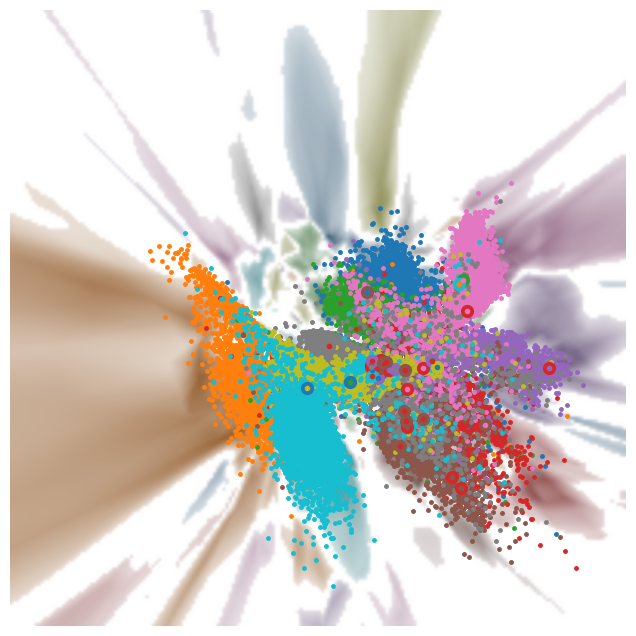

In [16]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, S,I, np.dot(ref_provider.train_representation(200),R), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 3169.00it/s]


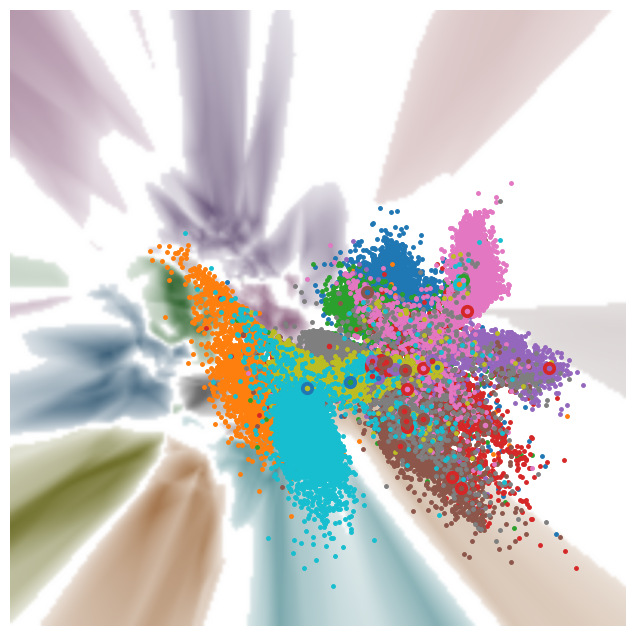

In [19]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
tar_projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from alignment.trans_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, S,I, np.dot(ref_provider.train_representation(200),R), projector, tar_projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))